<a href="https://colab.research.google.com/github/giardinas-dev/ml-traditional-sklearn/blob/main/Classificazione_di_frutti_esotici.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,PolynomialFeatures,OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.metrics import accuracy_score,log_loss
from sklearn.model_selection import KFold,cross_validate,learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

RANDOMSEED = 2

In [ ]:
from math import sqrt
# Funzione per valutare le performance di un modello su un dataset
def evaluate(model, dataset_x, dataset_y):
  y = dataset_y
  y_pred = model.predict(dataset_x)
  y_pred_proba = model.predict_proba(dataset_x)
  return accuracy_score(y,y_pred),log_loss(y,y_pred_proba),y_pred,y_pred_proba

In [ ]:
# Funzione che addestra il modello e valuta sia sul train che sul test set
def fit_and_evaluate(model,train,test):
  x_train ,y_train = train
  model.fit(x_train ,y_train)
  accuracy,logloss,y_pred,y_proba = evaluate(model,x_train,y_train)
  train = {'accuracy':accuracy,'logloss':logloss}
  x_test,y_test = test
  accuracy,logloss,y_pred,y_proba  = evaluate(model,x_test,y_test)
  test = {'accuracy':accuracy,'logloss':logloss,'y_pred':y_pred,'y_proba_pred':y_proba}
  return train,test

In [ ]:
# Funzione che esegue cross-validation e restituisce le medie degli score di accuracy e logloss per train e test

# NB: scikit-learn inverte il segno del log loss (neg-log-loss) per usarlo come “score” per tale motivo la funzione mette un segno meno
# nel return

def cross_validation(model,x,y):

  pipeline = make_pipeline(StandardScaler(), model )

  cv = KFold(n_splits=5, shuffle=True, random_state=RANDOMSEED)
  scores = cross_validate(
  pipeline, x, y,
  cv=cv,
  scoring=['accuracy', 'neg_log_loss'],
  return_train_score=True
  )
  return  np.array(scores['train_accuracy']).mean(),np.array(scores['test_accuracy']).mean(),-(np.array(scores['train_neg_log_loss']).mean()),-(np.array(scores['test_neg_log_loss']).mean())




**STANDARDIZZAZIONE**

È stata applicata una standardizzazione a tutte le feature numeriche , tramite *StandardScaler*, al fine di garantire che tutte le feature abbiano pari importanza nell'analisi.

**TRASFORMAZIONE FEATURES**

Non è stata applicata una trasformazione polinomiale in quanto quest'ultima nasce per introdurre "non-linearità" nel comportamento del modello, tuttavia il modello KNN non "apprende" una funzione , ma si basa semplicemente su distanze locali.

**SCELTA DEL MODELLO**


Data una regola empirica comune :

$$ 𝑘 ≈ \sqrt{n}$$
 dove *k* è il numero di osservazioni e *n* è il numero dei samples.

 Ed un dataset di 500 samples sono stati implementati e confrontati i seguenti modelli di classificatore KNN:

- *k* osservazioni in un range tra 10 e 22 ($\sqrt{500}≈22$) dove il limite inferiore aiuta a evitare l’overfitting.

- parametro *p* nella scelta della distanza di *Minkowski*

- *k* osservazioni in un range tra 25 e 40 che performa bene nel caso di *cross validation*

A scopo esplorativo, si presenta anche l'analisi di un classificatore RNN con raggio variabile.

**CROSS VALIDATION E IPERPARAMETRI**


È stata effettuata una 5‑fold cross-validation su tutto il dataset utilizzando la coppia *accuracy* - *logloss* come metriche di scoring.

Sono stati testati diversi valori di k per valutare le metriche sullo *split classico*  (10-12-15-17-18-20) e sulla *cross validation*  (25-30-40).


È stato scelto come *“modello migliore”* quello con *Accuracy* sul test set maggiore di 0.93 e *Logloss* < 0.19 nel caso K basso. Al contrario, si è preferito rendere meno stringenti i parametri di performance al fine di garantire buone performance ma al contempo una discreta stabilità.



In [ ]:
# Funzione per stampare performance di un modello
def printPerformance(title, train_score_accuracy, test_score_accuracy,
                     train_score_logloss, test_score_logloss,
                     train_result, test_result):
    """
    Stampa un report di performance con formato tabellare professionale.

    Parametri:
    - title (str): Titolo del modello e parametri.
    - train_score_accuracy (float): Accuracy media in cross-validation sul training set.
    - test_score_accuracy (float): Accuracy media in cross-validation sul test set.
    - train_score_logloss (float): LogLoss medio in cross-validation sul training set.
    - test_score_logloss (float): LogLoss medio in cross-validation sul test set.
    - train_result (dict): Metriche sul training split classico (keys: 'accuracy', 'logloss').
    - test_result (dict): Metriche sul test split classico (keys: 'accuracy', 'logloss').
    """

    # Costruzione del DataFrame delle metriche
    metrics = pd.DataFrame([
        {"Dataset": "CV Train",     "Accuracy": train_score_accuracy,     "LogLoss": train_score_logloss},
        {"Dataset": "CV Test",      "Accuracy": test_score_accuracy,      "LogLoss": test_score_logloss},
        {"Dataset": "Split Train",  "Accuracy": train_result['accuracy'],  "LogLoss": train_result['logloss']},
        {"Dataset": "Split Test",   "Accuracy": test_result['accuracy'],   "LogLoss": test_result['logloss']}
    ])

    # Stampa del report
    print(f"\n{title}")
    print("-" * len(title))
    print(metrics.to_string(index=False, float_format="{:.3f}".format))
    print("\n")

In [ ]:
# Funzione principale per testare modelli di classificatore KNN / RNN

def test_models(train, test, x , y):

  best_model = []
  models = []

  train_x,train_y = train
  test_x,test_y = test

  # Standardizzazione delle feature ( media 0 , deviazione standard 1 )
  ss = StandardScaler()
  train_x = ss.fit_transform(train_x)
  test_x = ss.transform(test_x)

  # Analizziamo valori di K osservazioni da considerare
  ks = [10,12,15,17,18,20,25,30,40,50]

  for k in ks:
    # valutiamo i modelli al variare di p per la distanza
    for p in [2,3]:
      knn = KNeighborsClassifier(n_neighbors=k,   metric='minkowski',  # tipo di distanza
                                p=p  )

      # Valutazione tramite cross-validation (su tutto x, y)
      train_score_accuracy, test_score_accuracy, train_score_logloss, test_score_logloss = cross_validation(knn,x,y)
      # Fit e valutazione sui set train/test
      train_result ,test_result = fit_and_evaluate(knn,(train_x,train_y),(test_x,test_y))

      # Stampa risultati solo se  è sopra soglia ( buona performance )
      if test_result['accuracy']>0.92  or test_result['logloss'] <= 0.20  :
        printPerformance(f"MODELLO:KNN PARAMETRO K :{str(k)} PARAMETRO P:{str(p)}",train_score_accuracy,
                       test_score_accuracy, train_score_logloss, test_score_logloss,train_result ,test_result )


      # Selezioniamo i modelli per grafici di rendimento
      model = {'model':knn,
               'name':"KNN",
               'k':str(k),
               'p':str(p),
               'train':train_result,
               'test':test_result,
               'CV test' : {'accuracy':test_score_accuracy,'logloss':test_score_logloss},
               'CV train' : {'accuracy':train_score_accuracy,'logloss':train_score_logloss},
               'test x':test_x,
               'test y':test_y
              }
      models.append(model)

      # Selezioniamo i migliori modelli per analisi performance
      if ( test_result['accuracy']>= 0.93  and test_result['logloss'] <= 0.218 ) :
           best_model.append(model)

  # Analizziamo valori di R distanza da considerare in un variante del KNN,
  r_values = [0.3,0.7,1.0,1.2,1.5,2.0,2.5,3.5] # La mediana della distanza euclidea tra i punti scalati è circa 3.05
  for r in r_values:
    rnn = RadiusNeighborsClassifier(radius=r, weights='distance', metric='euclidean', outlier_label='most_frequent')

    train_score_accuracy, test_score_accuracy, train_score_logloss, test_score_logloss = cross_validation(rnn,x,y)
    # Fit e valutazione sui set train/test
    train_result ,test_result = fit_and_evaluate(rnn,(train_x,train_y),(test_x,test_y))
    if test_result['accuracy']>0.92  and test_result['logloss'] <= 0.40  :
      printPerformance(f"MODELLO:RNN PARAMETRO R :{str(r)}",train_score_accuracy,
                       test_score_accuracy, train_score_logloss, test_score_logloss,train_result ,test_result )
      model = {'model':rnn,
               'name':"RNN",
               'r':str(r),
               'train':train_result,
               'test':test_result,
               'CV test' : {'accuracy':test_score_accuracy,'logloss':test_score_logloss},
               'CV train' : {'accuracy':train_score_accuracy,'logloss':train_score_logloss},
               'test x':test_x,
               'test y':test_y
              }
      best_model.append(model)



  return best_model,models





In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Matrice di confusione
def MatrixConfusion(model,class_names):
  cm = confusion_matrix(model['test y'], model['test']['y_pred'])
  title = f"Confusion Matrix KNN k={model['k']}" if 'k' in model else f"Confusion Matrix RNN r={model['r']}"

# 2. Visualizzazione con ConfusionMatrixDisplay
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)  # class_names = lista nomi classi

# 3. Plot
  fig, ax = plt.subplots(figsize=(6, 6))
  disp.plot(cmap='Blues', ax=ax, colorbar=False)
  plt.title(title)
  plt.xticks(rotation=45)
  plt.yticks(rotation=0)
  plt.tight_layout()
  plt.show()

In [ ]:
# Funzione per visualizzare la curva di apprendimento (learning curve)
def showLearning_curves(title, models, x, y):
    sns.set_theme()
    plt.figure(figsize=(10,6))
      # Genera punti più fitti tra 300 e 500
    train_sizes = np.unique(np.concatenate([
        np.linspace(50, 299, 5, dtype=int),
        np.linspace(300, 400, 10, dtype=int),
    ]))


    for m in models:
        model = m['model']
        if 'k' in m.keys():
          k = m['k']  # Dato un modello KNN
        else :
          r = m['r'] #  nel caso di RNN

        train_size_abs, train_scores, test_scores = learning_curve(
            model,
            x,
            y,
           # train_sizes=train_sizes,
            scoring='accuracy',
            random_state=RANDOMSEED
        )

        # Media delle score su più split
        train_mean = train_scores.mean(axis=1)
        test_mean = test_scores.mean(axis=1)

        # Plot separati per ogni valore di k osservazioni / distanza r
        if 'k' in m.keys():
          plt.plot(train_size_abs, train_mean, linestyle='--', label=f"KNN Train (k={k})")
          plt.plot(train_size_abs, test_mean, linestyle='-', label=f"KNN Test (k={k})")
        else:
          plt.plot(train_size_abs, train_mean, linestyle='--', label=f"RNN Train (r={r})")
          plt.plot(train_size_abs, test_mean, linestyle='-', label=f"RNN Test (r={r})")


    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:

# Funzioni per visualizzare metriche al variare di k e p, permette di valutare la scelta dell'iperparametro
def LinePlotLogloss(models):
    # Creiamo una lista di record per il DataFrame
    records = []
    for res in models:
        k = int(res['k'])
        p = res['p']
        train = res['train']['logloss']
        test = res['test']['logloss']
        train_cv = res['CV train']['logloss']
        test_cv = res['CV test']['logloss']
        records.append({'k': k, 'p': p, 'legend': 'train split', 'logloss': train})
        records.append({'k': k, 'p': p, 'legend': 'test split', 'logloss': test})
        records.append({'k': k, 'p': p, 'legend': 'cross val train', 'logloss': train_cv})
        records.append({'k': k, 'p': p, 'legend': 'cross val test', 'logloss': test_cv})

    # DataFrame ordinato per k
    df = pd.DataFrame(records)
    df = df.sort_values("k")
    unique_k = sorted(df['k'].unique())

    # Grafico
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x='k', y='logloss', hue='legend', style='p', markers=True, dashes=False)

    # Intervallo x "più largo" e spostato
    min_k = min(unique_k)
    max_k = max(unique_k)
    plt.xlim(min_k + 20, max_k + 1)  # Sposta a destra

    # Più spazio tra i tick
    plt.xticks(np.arange(min_k, max_k + 1, step=4))

    plt.title("Logloss su train e test per diversi valori di k e p")
    plt.xlabel("Valore di k")
    plt.ylabel('Logloss')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def BarPlotAccuracy(models):
   # Creiamo una lista di record per il DataFrame
  k_values = list(map(lambda x:x['k'],models))
  accuracies_test = list(map(lambda x:x['test']['accuracy'],models))
  accuracies_train = list(map(lambda x:x['train']['accuracy'],models))
  accuracies_test_cv = list(map(lambda x:x['CV test']['accuracy'],models))
  accuracies_train_cv = list(map(lambda x:x['CV train']['accuracy'],models))

  # Bar plot affiancato
  x = np.arange(len(k_values))  # posizione delle barre
  width = 0.35

  plt.figure(figsize=(12, 6))
  plt.bar(x - width/2, accuracies_test, width, label='Test', color='orange')
  plt.bar(x + width/2, accuracies_train, width, label='Train ', color='skyblue')
  plt.bar(x - width/2, accuracies_test_cv, width, label='Test (CV)', color='red')
  plt.bar(x + width/2, accuracies_train_cv, width, label='train (CV)', color='green')


  plt.xlabel("Valore di k")
  plt.ylabel("Accuracy")
  plt.title("Accuracy train vs test al variare di k")
  plt.xticks(x, k_values)
  plt.ylim(0.925, 0.942)
  plt.legend()
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.tight_layout()
  plt.show()

   # Il codice di queste funzioni per la realizzazione dei grafici è stato realizzato in parte con l'aiuto di chat-GPT.



In [ ]:
# Funzione per trovare outliers con il metodo IQR
def find_outliers_iqr(data, column,lower_limit,upper_limit = None):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = max(Q1 - 1.5 * IQR,lower_limit)
    if upper_limit is not None:
      upper_bound = min(Q3 + 1.5 * IQR,upper_limit)
    else:
      upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

In [ ]:

source_csv = 'https://proai-datasets.s3.eu-west-3.amazonaws.com/fruits.csv'

df = pd.read_csv(source_csv)

df.head()



,Frutto,Peso (g),Diametro medio (mm),Lunghezza media (mm),Durezza buccia (1-10),Dolcezza (1-10)
0,Mela,86.40,89.68,8.69,9.61,2.41
1,Mela,77.58,73.45,6.49,7.20,3.87
2,Mela,81.95,81.66,6.40,9.09,2.88
3,Mela,66.33,36.71,6.78,8.21,2.55
4,Mela,56.73,75.69,5.78,9.15,3.88


**Gestione dei Valori Mancanti**

È stata effettuata una verifica dei valori nulli tramite *df.isna().sum()* e *df.info()*.
Non sono stati rilevati valori mancanti, quindi non è stato necessario effettuare operazioni di imputazione o rimozione.

**Separazione del Target**

La variabile target **Frutto** è stata correttamente separata dal dataset.

**Label Encoding**

 Le variabili presenti hanno valori continui, quindi non è necessaria alcuna trasformazione di *Label Encoding*.

In [ ]:
print(df.describe())
#stampiamo le informazioni generali sui valori possibili delle features


print(df.isna().sum())
#controlliamo che tutti i valori delle features non siano nulli nelle varie osservazioni

print(df.info())
#controlliamo il tipo delle features per capire eventuale label encoding per variabili qualitative

         Peso (g)  Diametro medio (mm)  Lunghezza media (mm)  \
count  500.000000           500.000000            500.000000   
mean    47.313440            86.573100              5.298620   
std     26.768797            64.293403              2.641993   
min      8.570000             7.530000              1.150000   
25%     24.797500            50.510000              2.672500   
50%     42.380000            70.450000              5.670000   
75%     68.080000            88.852500              7.455000   
max    111.210000           299.890000             11.140000   

       Durezza buccia (1-10)  Dolcezza (1-10)  
count             500.000000       500.000000  
mean                7.437640         3.593220  
std                 1.812548         1.264899  
min                 3.070000         1.250000  
25%                 6.152500         2.570000  
50%                 7.340000         3.535000  
75%                 8.615000         4.465000  
max                13.720000         6.

**Ricerca dei Outliers**

Sono stati realizzati degli histplot e boxplot relativi alla distribuzione dei valori delle feature all'interno del dataset.
Sono stati rilevati valori anomali facilmente visibili in "*Diametro medio (mm)*" e "*Durezza buccia (1-10)*".


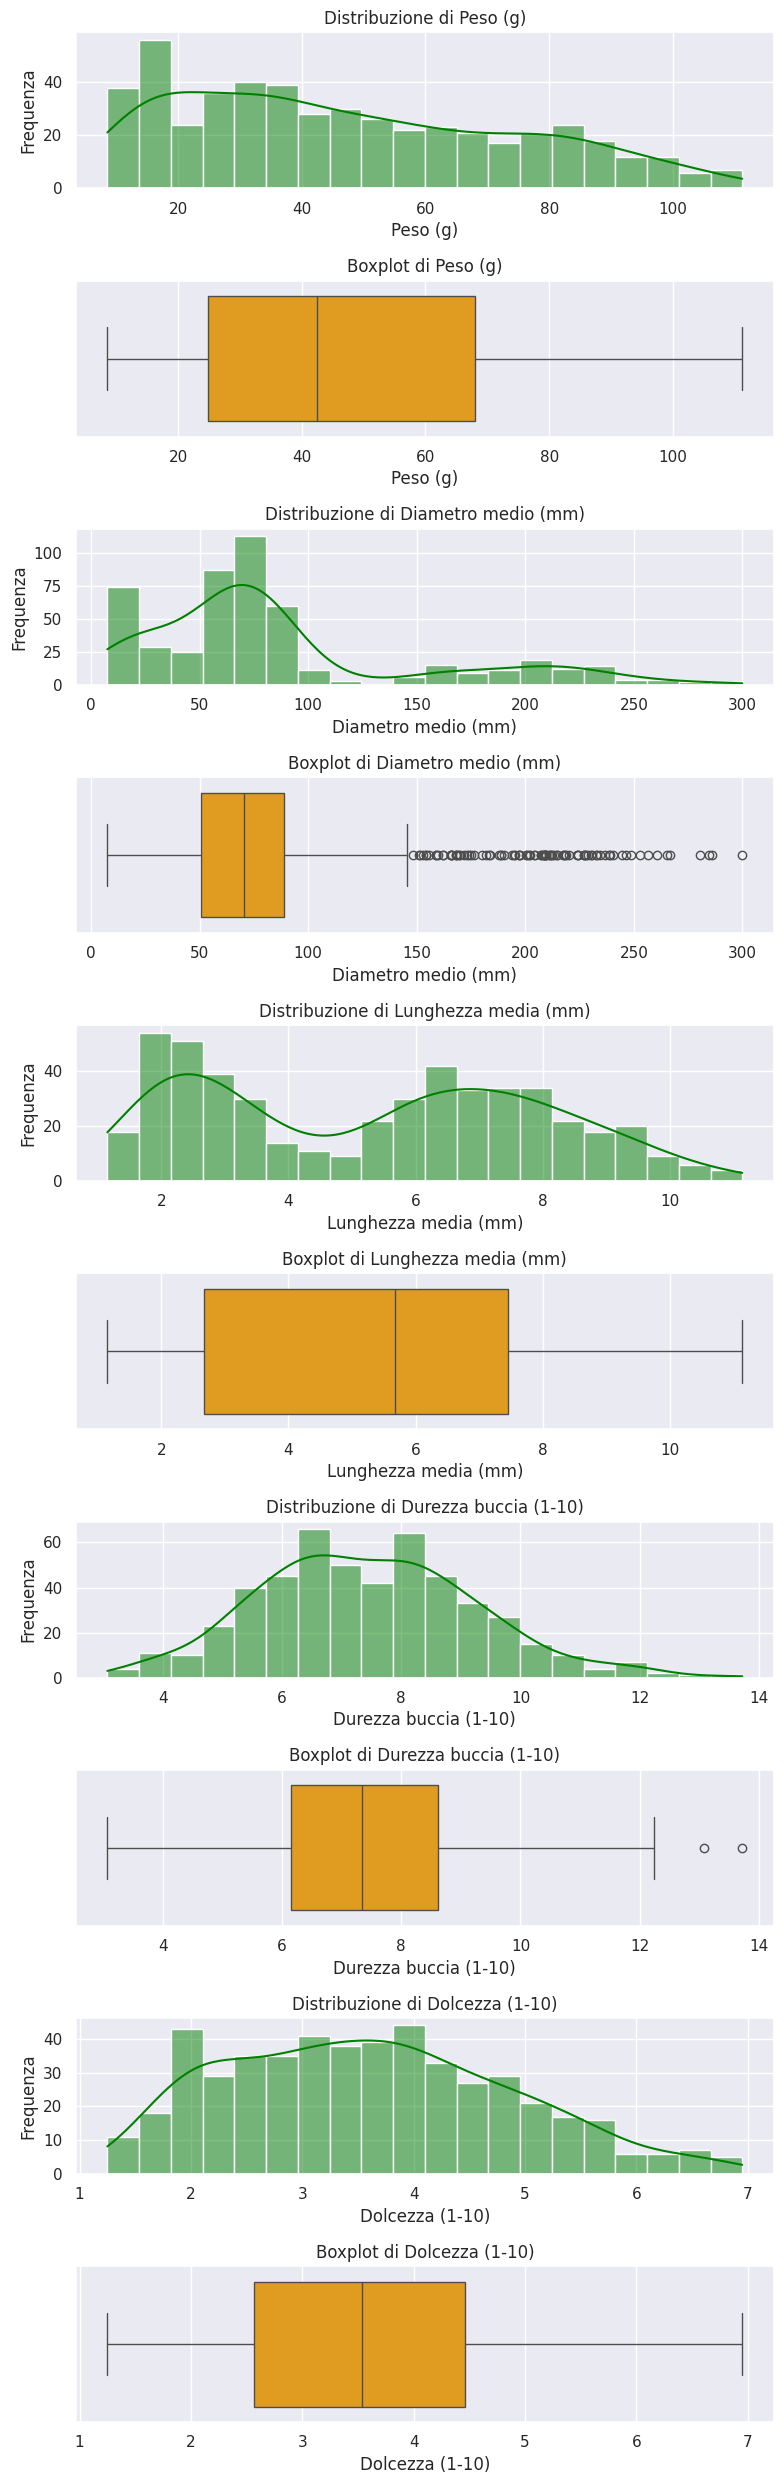

In [ ]:

# Lista delle features
features = df.drop(columns=['Frutto']).columns.tolist()

plt.figure(figsize=(8, 5 * len(features)))  # Altezza adattata al doppio dei plot per ogni feature
for i, feature in enumerate(features):
    # Histplot
    plt.subplot(len(features)*2, 1, 2*i + 1)
    sns.histplot(df[feature], kde=True, bins=20, color='green')
    plt.title(f'Distribuzione di {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequenza')

    # Boxplot
    plt.subplot(len(features)*2, 1, 2*i + 2)
    sns.boxplot(data=df, x=feature, color='orange')
    plt.title(f'Boxplot di {feature}')
    plt.xlabel(feature)

plt.tight_layout()
plt.show()


**Visualizzazione degli Outliers**


E' stata svolta un'analisi degli outliers presenti nelle varie features attraverso il metodo IQR (Interquartile Range), ma limitando i valori minimi e massimi con soglie specifiche (lower_limit e upper_limit), al fine di mantenere una coerenza nei valori proposti.


In [ ]:


features_cont = df.drop(columns=['Frutto','Durezza buccia (1-10)', 'Dolcezza (1-10)']).columns.tolist()
features_discrete = ['Durezza buccia (1-10)', 'Dolcezza (1-10)']

pd.set_option('display.max_rows', 20)
for f in features_cont:
  outliers = find_outliers_iqr(df,f,0)
  print("-------------------------------------")
  print(f"{len(outliers)}  Outlier trovati per '{f}':\n{outliers if len(outliers) > 0 else ''}")

for f in features_discrete:
  outliers = find_outliers_iqr(df,f,0,10)
  print("-------------------------------------")
  print(f"{len(outliers)} Outlier trovati per '{f}':\n{outliers if len(outliers) > 0 else ''}")


-------------------------------------
0  Outlier trovati per 'Peso (g)':

-------------------------------------
133  Outlier trovati per 'Diametro medio (mm)':
     Frutto  Peso (g)  Diametro medio (mm)  Lunghezza media (mm)  \
101  Banana     20.04             5.325981                  2.77   
102  Banana     35.37             5.276685                  3.24   
103  Banana     20.96             5.429609                  2.77   
104  Banana     22.64             5.339123                  4.00   
105  Banana     29.30             5.392035                  2.78   
..      ...       ...                  ...                   ...   
395     Uva     16.70             2.624669                  1.56   
396     Uva     17.70             3.137232                  2.53   
397     Uva     19.50             3.064325                  1.66   
398     Uva     17.57             3.023347                  1.83   
399     Uva     16.72             2.946542                  2.26   

     Durezza buccia (1-

In [ ]:
# Analizziamo in dettaglio gli outliers di Diametro medio e Durezza Buccia
outliers_diametro = find_outliers_iqr(df,'Diametro medio (mm)',0)
outliers_durezza = find_outliers_iqr(df,'Durezza buccia (1-10)',0, 10)

# Mostra outliers
pd.set_option('display.max_rows', 500)
print(outliers_diametro)
print(outliers_durezza)


     Frutto  Peso (g)  Diametro medio (mm)  Lunghezza media (mm)  \
101  Banana     20.04             5.325981                  2.77   
102  Banana     35.37             5.276685                  3.24   
103  Banana     20.96             5.429609                  2.77   
104  Banana     22.64             5.339123                  4.00   
105  Banana     29.30             5.392035                  2.78   
106  Banana     31.51             5.454509                  3.82   
108  Banana     39.31             5.358848                  1.61   
109  Banana     32.70             5.289831                  2.21   
110  Banana     22.42             5.389528                  3.06   
112  Banana     24.52             5.346059                  3.24   
114  Banana     12.99             5.654837                  2.03   
116  Banana     25.23             5.341951                  3.65   
117  Banana     36.57             5.348963                  4.28   
120  Banana     26.94             5.339267      

**Analisi Preprocessing**

- Feature *Diametro Medio*

Per quanto riguarda gli outliers relativi al "Diametro Medio" possiamo concludere che i campioni in questione, appartanenti alla classe Banana, frutto notoriamente caratterizzato da un'elevata varianza di dimensioni ( anche molto grandi rispetto alla media ), sono plausibili anche se anomali rispetto alla media. Tuttavia per evitare che tali valori esercitino un'influenza eccessiva sul calcolo delle distanza relativa al modello KNN ( sensibile alla scala delle feature ) , si è scelto di applicare una trasformazione logaritmica alla feature "Diametro medio (mm)", cosi da ridurre l'impatto degli outlier mantenendo comunque l'informazione strutturale dei dati.

- Feature *Durezza Buccia*

Gli outliers relativi a "Durezza Buccia", nella maggior parte dei casi presenti, sono facilmente riconoscibili come semplice rumore nell'acquisizione dei dati in quanto i campioni si caratterizzano per valori poco sopra soglia (*> 10* ).
Per tale motivo si è scelto di procedere ad un clipping dei valori intorno all'Upper Bound ( *10 < x < 11*) ed una rimozione dei campioni con valori evidentemente più elevati dell'upper bound ( *>11*).

In [ ]:
# Comando che ci permette di analizzare se la distruzione è asimmetrica ( verso un lato )
# > 1 skewed positivamente
# < -1 skewed negativamente

#Valore pre-processing
print(df['Diametro medio (mm)'].skew())

df['Diametro medio (mm)'] = np.log1p(df['Diametro medio (mm)'])

#Valore post trasformazione logaritmo
print(df['Diametro medio (mm)'].skew())


df['Durezza buccia (1-10)'] = df['Durezza buccia (1-10)'].apply(lambda x: 10 if 10 <= x < 11 else x)

# Rimuovere valori >= 11
df = df[df['Durezza buccia (1-10)'] < 11]




0.4147338832522848
-0.3109685570244766
0.06256923278463446
-0.15113387223920613
0.35036242421493696


In [ ]:

#togliamo la colonna target
x = df.drop('Frutto',axis = 1).values

y = df['Frutto'].values

list_class = df['Frutto'].unique().tolist()

In [ ]:
from gc import collect
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state= RANDOMSEED)



best,models = test_models((X_train,y_train),(X_test,y_test),x,y)




# si è deciso di escludere tra i modelli performanti (best) il modello KNN con k = 10 in quanto la metrica del logloss non era particolarmente eccellente
# rendendo le previsioni meno "sicure" rispetto ai modelli con K=15/17 o K = 30



MODELLO:KNN PARAMETRO K :10 PARAMETRO P:2
-----------------------------------------
    Dataset  Accuracy  LogLoss
   CV Train     0.934    0.157
    CV Test     0.907    0.409
Split Train     0.935    0.159
 Split Test     0.938    0.523



MODELLO:KNN PARAMETRO K :10 PARAMETRO P:3
-----------------------------------------
    Dataset  Accuracy  LogLoss
   CV Train     0.932    0.157
    CV Test     0.913    0.475
Split Train     0.930    0.160
 Split Test     0.938    0.521



MODELLO:KNN PARAMETRO K :12 PARAMETRO P:2
-----------------------------------------
    Dataset  Accuracy  LogLoss
   CV Train     0.932    0.164
    CV Test     0.911    0.339
Split Train     0.933    0.168
 Split Test     0.928    0.180



MODELLO:KNN PARAMETRO K :12 PARAMETRO P:3
-----------------------------------------
    Dataset  Accuracy  LogLoss
   CV Train     0.931    0.167
    CV Test     0.905    0.337
Split Train     0.933    0.168
 Split Test     0.918    0.177



MODELLO:KNN PARAMETRO K :15 PAR

Modello leggermente più “reattivo” ai dati vicini, ma probabilmente meno stabile e con probabilità meno calibrate (*Logloss* più alto):

- Modelli K piccoli (10):
  - *Accuracy* test CV intorno a 0.92-0.93.
  - *Logloss* test CV piuttosto alto (0.38-0.4).

Modelli con  K=15,p=3  K=17,p=3 hanno un'ottima combinazione di *Accuracy* (0.93-0.94) e *Logloss* più basso (0.25-0.26):

- K medi (12-20):
 - *Accuracy* test CV sale leggermente (0.94-0.95).
 - *Logloss* test CV diminuisce, in particolare con p=3 e p = 2, segno che la stima delle probabilità migliora.

Modelli che mostrano buon equilibrio k=30 tra accuracy (0.94) e logloss (0.21):

- K alti (30):
 - *Accuracy* test CV stabile attorno a 0.91.
 - *Logloss* test CV generalmente più basso rispetto a K piccoli, spesso intorno a 0.28-0.29.


Modelli di RNN con r tra 1.5 e 2.0 presentano una buona accuracy (0.93), un basso logloss ma un leggero overfitting relativo alla marcata differenza tra le performance del training set e del test set.




**SCELTA DEI MODELLI MIGLIORI:**


**MODELLO KNN CON K :15 P:3**

- CROSS VALIDATION
-- TRAIN
 -- ACCURACY : 0.933
 -- LOGLOSS :0.175
-- TEST
 -- ACCURACY : 0.905
 -- LOGLOSS : 0.342
- TRAIN/TEST SPLIT EVALUATION
-- TRAIN SET
 -- ACCURACY : 0.933
 -- LOGLOSS : 0.177
-- TEST SET
 -- ACCURACY : 0.948
 -- LOGLOSS : 0.180









**MODELLO KNN CON K :17 P:3**
- CROSS VALIDATION
-- TRAIN
 -- ACCURACY : 0.934
 -- LOGLOSS :0.179
-- TEST
 -- ACCURACY : 0.907
 -- LOGLOSS : 0.348
- TRAIN/TEST SPLIT EVALUATION
-- TRAIN SET
 -- ACCURACY : 0.930
 -- LOGLOSS : 0.180
-- TEST SET
 -- ACCURACY : 0.938
 -- LOGLOSS : 0.192





**MODELLO KNN CON K:30 P:2**
- CROSS VALIDATION
-- TRAIN
 -- ACCURACY : 0.927
 -- LOGLOSS :0.205
-- TEST
 -- ACCURACY : 0.913
 -- LOGLOSS : 0.294
- TRAIN/TEST SPLIT EVALUATION
-- TRAIN SET
 -- ACCURACY : 0.920
 -- LOGLOSS : 0.207
-- TEST SET
 -- ACCURACY : 0.938
 -- LOGLOSS : 0.215


**MODELLO:RNN PARAMETRO R :1.5**
- CROSS VALIDATION
-- TRAIN
 -- ACCURACY : 1.0
 -- LOGLOSS :0.0
-- TEST
 -- ACCURACY : 0.909
 -- LOGLOSS : 0.315
- TRAIN/TEST SPLIT EVALUATION
-- TRAIN SET
 -- ACCURACY : 1.0
 -- LOGLOSS : 0.0
-- TEST SET
 -- ACCURACY : 0.928
 -- LOGLOSS : 0.219







**ANALISI RISULTATI**



Modelli con K troppo basso tendono a fornire predizioni meno stabili e probabilità meno affidabili (*LogLoss* alto).

Con l’aumento di K, il modello diventa più *“liscio”*, più stabile, con probabilità più calibrate (*LogLoss* migliore) e accuratezza leggermente migliore o stabile.

Il parametro p influenza la metrica di distanza: valori diversi danno risultati simili, ma si nota una leggera preferenza per p=2 (distanza Euclidea) o p=3, con prestazioni leggermente migliori.

Modelli con K alto (30) non mostrano overfitting (train accuracy non è molto più alta del test) e sono buone opzioni nel caso si preferisca un modello pià stabile e generalizzabile.

Come già riportato precedentemente i modelli di RNN riportati presentano una buona accuracy (0.93), un basso logloss ma un significativo overfitting visibile nella learning curve seguente.



**CONCLUSIONE**

Il modello con K=30, p=2 offre una maggiore stabilità, buona accuratezza (0.938) e *LogLoss* basso (0.21), inoltre fornisce risultati simili tra cross validation e split classico.

Al contrario un modello un po’ più “reattivo” si ha con K=17 p=3 / K=15, che rappresenta un buon compromesso tra *Accuracy*  test CV intorno a 0.94-0.95 e *Logloss* basso.
Un'alternativa valida è il modello con k=12 che mostra *Logloss* e un'*Accuracy* efficace, nonostante sia meno generalizzabile dei precedenti.

La scelta del KNN nella totalità dei modelli analizzati rappresenta un buon classificatore per il problema proposto caratterizzandosi per metriche affidabili** e risultati ragionevoli.

Per completezza si riportano anche i modelli migliori per un eventuale utilizzo del modello *RNN* con raggio-distanza 1.5  che si caratterizzano per buone performance nel caso di dataset con densità variabile e una classificazione maggiormente prudente (poco generalizzabile).

** *Logloss* sullo 0.2 è ottimo per un classificatore non binario.





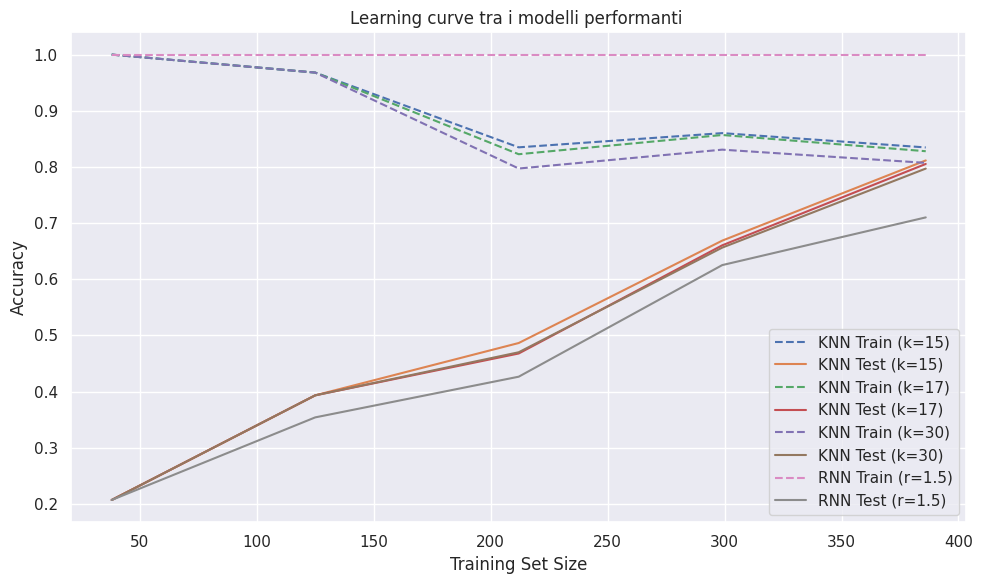

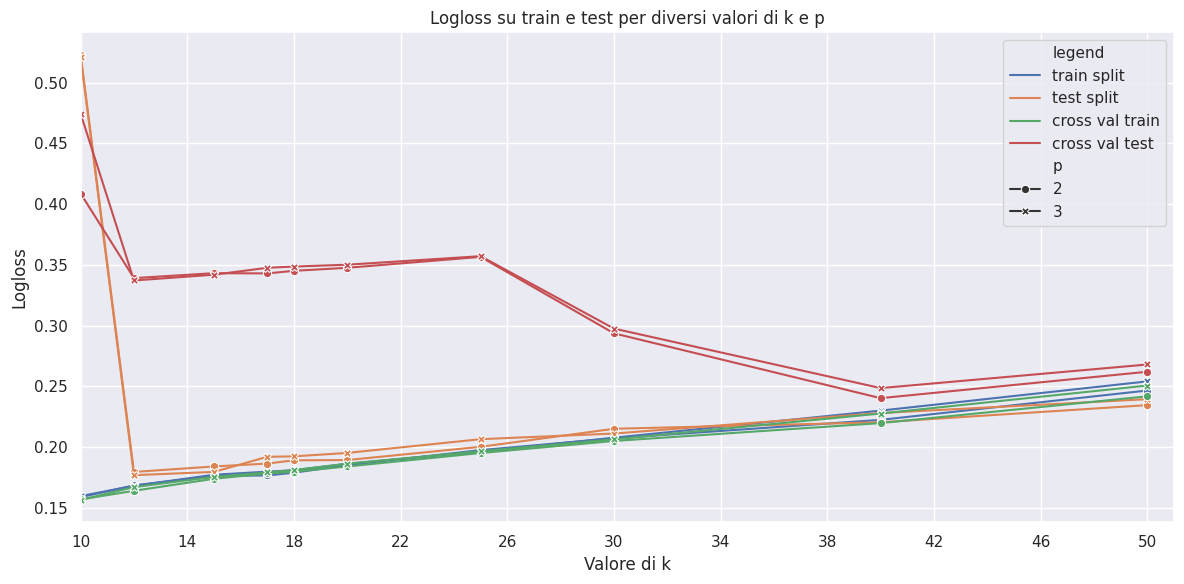

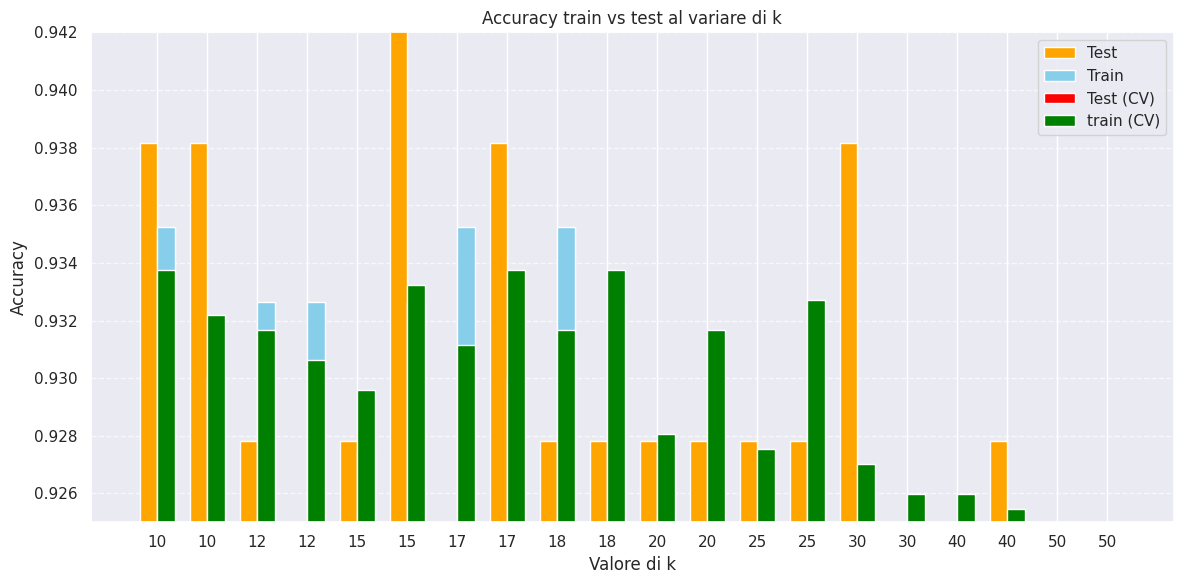

In [ ]:
showLearning_curves("Learning curve tra i modelli performanti ", best, x, y)
LinePlotLogloss(models)
BarPlotAccuracy(models)

- È stata generata la curva di apprendimento (*learning curve*) per ogni modello, nonostante non abbia un processo di apprendimento ( *KNN Lazy* ) in senso classico, quest'ultima permette di valutare quanto il modello generalizza al crescere dei dati ( *manifesta l'overfitting nel caso di RNN* ).



- È stato realizzato un plot relativo alle performance (*logloss* / *accuracy*) al variare di k. I due grafici, facilmente sovrapponibili, mostrano da un lato come l'accuratezza tenda a diminuire all'aumentare di K e dall'altro come il logloss tenda a stabilizzarsi per K > 20.


A fine report sono riportate anche le matrici di confusione relative ai migliori 4 modelli analizzati.
E' evidente come gli errori si localizzino tra target *simili*  (date le features) quali Mela e Arancia, a conferma della capacità discriminativa del modello.

NB: Il codice relativo ai plot è stato realizzato attraverso l'uso di Chat-GPT.

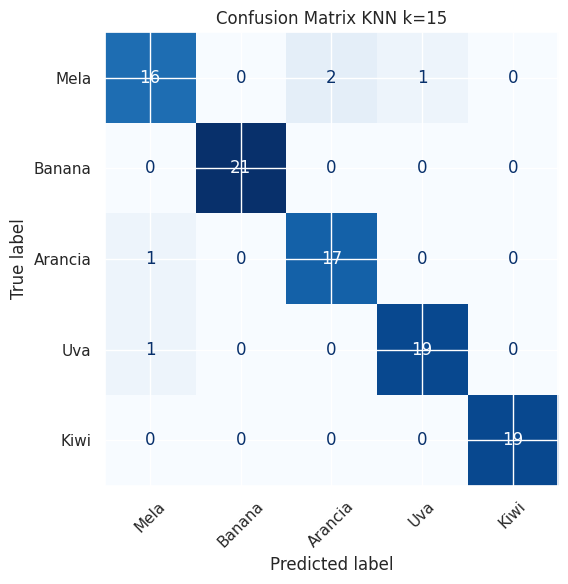

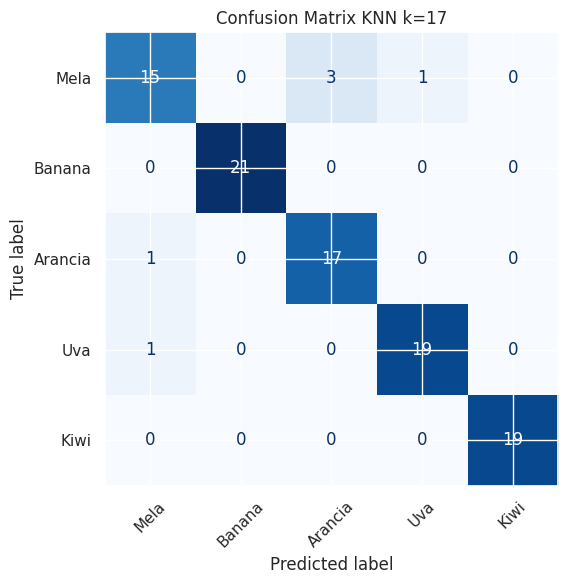

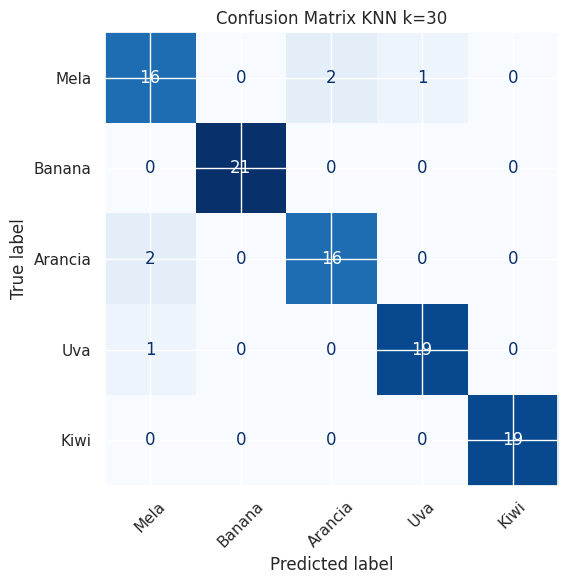

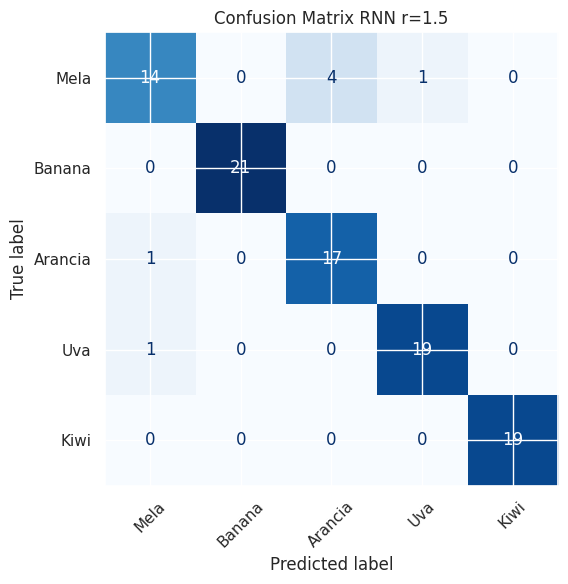

In [ ]:
for model in best:
  MatrixConfusion(model,list_class)